# От RNN к LSTM, GRU 

## Проблема долгосрочного запоминания и появление гейтов

Классическая RNN эффективно анализирует последовательности — например, предсказывает следующее слово. Но обучение RNN сопряжено с рядом трудностей, одна из них — слабая способность сети к долгосрочному запоминанию.

Проблема долгосрочного запоминания — это неспособность RNN сохранять информацию на длинных промежутках. Когда ошибка обратно распространяется во времени, токены, которые нейросеть видела много шагов назад, имеют малые значения градиентов и обновляются не очень эффективно.

Как результат, RNN плохо «помнит» события, случившиеся много шагов назад. Это можно считать эффектом от проблемы затухания градиентов. 

Частично эта проблема решается стабилизацией обучения, но можно использовать и дополнительные подходы.  

Чтобы дать нейросети возможность запоминать длинный контекст, были предложены архитектуры, которые используют гейты.

**Гейты** — специальные механизмы в архитектуре нейросети, которые позволяют ей избирательно сохранять или удалять информацию.  

Внутри ячеек для каждого шага последовательно вычисляются специальные векторы-гейты (все значения от 0 до 1), которые решают, какую часть информации пропустить дальше, а какую — отбросить. Благодаря такой выборочной «фильтрации» сеть приобретает способность учитывать полезные токены, даже если она «видела» их давно. 


# Архитектуры LSTM и GRU

## Добавление гейтов в классическую RNN привело к созданию архитектур LSTM и GRU. 

Разберёмся, как устроены гейты «под капотом» и как они встраиваются в RNN. 

### LSTM

**LSTM** (Long Short-Term Memory — англ. механизм длительной кратковременной памяти) — это архитектура, специально разработанная для решения проблемы долгосрочной зависимости. Она добавляет:

- cell state — состояние, в котором информация передаётся без сильных изменений;

<u>три гейта</u>: **забывающий** (forget gate), **входной** (input gate) и **выходной** (output gate).
    
- Забывающий (forget) гейт позволяет удалить устаревшую или нерелевантную информацию. Он решает: «Стоит ли забыть то, что мы уже знаем?».

- Входной (input) гейт фильтрует текущий вход. Он отвечает на вопрос: «Нужно ли сохранить новую информацию, которая только что пришла?».

- Выходной (output) гейт определяет, какую часть памяти использовать для генерации выхода. Он решает: «Что из внутренней памяти стоит выдать на следующем шаге?».

Таким образом, LSTM — это тоже рекуррентная нейронная сеть, но её рекуррентный блок дополнен гейтами — векторами, которые решают, что делать с полученной информацией.
Формулы для обработки токена на позиции $t$ выглядят так:

- Forget gate
$$
f_t​=σ(W_f​[h_{t−1}​,x_t​]+b_f​)
$$
- Input gate
$$
i_t​=σ(W_i​[h_{t−1}​,x_t​]+b_i​)
$$
$$
\tilde{C}_t​=tanh(W_C​[h_{t−1}​,x_t​]+b_C​)
$$
- Обновление состояния
$$
C_t​=f_t​⋅C_{t−1}​+i_t​⋅\tilde{C}_t​
$$
- Output gate
$$
o_t​=σ(W_o​[h_{t−1}​,x_t​]+b_o​)
$$
$$
h_t​=o_t​⋅tanh(C_t​)
$$
Здесь:

- $x_t$​ — вход в момент времени t (токен или эмбеддинг токена),

- $h_{t−1}$​ — скрытое состояние предыдущего шага,
    
- $σ$ — сигмоида (функция активации),
    
- $tanh$ — гиперболический тангенс (тоже функция активации).
    Визуализация

Отличный и очень глубокий вопрос! Давайте разберём **LSTM с математической точки зрения**, но **шаг за шагом**, чтобы было понятно **не только «что»**, но и **«почему именно так»**.

---

## 🧩 Главная цель: **решить проблему затухающих градиентов**

В обычной RNN обновление скрытого состояния:
$$
h_t = \tanh(W x_t + U h_{t-1} + b)
$$

При обратном распространении ошибки градиент проходит через цепочку производных:
$$
\frac{\partial h_t}{\partial h_{t-1}} = \text{diag}(1 - h_t^2) \cdot U
$$

Производная $\tanh$ — это $1 - \tanh^2$, которая **всегда ≤ 1**.  
Если умножать такие числа много раз → градиент **затухает экспоненциально**.

> 🔥 **Идея LSTM**: **не пропускать градиент через нелинейности**, а дать ему **прямой путь**.

---

## 💡 Ключевой трюк: **ячейка памяти (cell state) `C_t`**

LSTM вводит **дополнительное состояние** — `C_t` — которое **обновляется аддитивно**, а не через $\tanh$:

$$
C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t
$$

- $\odot$ — поэлементное умножение,
- $f_t, i_t$ — ворота (от 0 до 1),
- $\tilde{C}_t$ — новая информация.

### Почему это спасает градиент?

Посмотрим на производную $C_t$ по $C_{t-1}$:

$$
\frac{\partial C_t}{\partial C_{t-1}} = f_t
$$

Если $f_t \approx 1$ («ничего не забывать»), то:
$$
\frac{\partial C_t}{\partial C_{t-1}} \approx 1
$$

→ градиент **проходит без затухания** через всю последовательность!

> ✅ Это **главный математический секрет LSTM**: **аддитивное обновление** + **управляемый поток** через ворота.

---

## 🔑 Почему именно сигмоида в воротах?

Сигмоида: $\sigma(x) = \frac{1}{1 + e^{-x}} \in (0, 1)$

- Она **непрерывна и дифференцируема** → можно обучать через backprop.
- Выход в $[0, 1]$ → идеально для **масштабирования**:  
  - $0$ = «полностью забыть»,  
  - $1$ = «полностью сохранить».

> 🎯 Это **контролируемый "кран"**, который учится регулировать поток информации.

---

## 📐 Почему $\tilde{C}_t = \tanh(\dots)$?

- $\tanh$ даёт значения в $[-1, 1]$ → **ограниченный диапазон**.
- Это **стабилизирует обновления**: новые значения не взрываются.
- Но главное: **это не мешает градиенту**, потому что $\tilde{C}_t$ **умножается на \(i_t\)** и **добавляется**, а не заменяет `C_t`.

---

## 🔄 Почему обновление именно такое?

$$
C_t = \underbrace{f_t \odot C_{t-1}}_{\text{«что оставить»}} + \underbrace{i_t \odot \tilde{C}_t}_{\text{«что добавить»}}
$$

Это **естественная модель памяти**:
- Сначала **решаем, что забыть** из старого (`f_t`),
- Потом **решаем, что запомнить** нового (`i_t`),
- И **аккуратно комбинируем**.

> Это как редактировать заметку:  
> - стереть устаревшее,  
> - дописать новое.

---

## 📉 А как с градиентом в воротах?

Да, ворота (`f_t`, `i_t`) сами зависят от $h_{t-1}$, и их градиенты могут затухать.  
**Но!** Основной сигнал (через `C_t`) **не зависит от них напрямую** — он идёт **в обход**.

> 🧠 LSTM — это **два пути**:  
> - **быстрый путь** через `C_t` (градиент ≈ 1),  
> - **медленный путь** через `h_t` (градиент может затухать, но он вторичен).

---

## 📐 Почему $h_t = o_t \odot \tanh(C_t)$?

- `C_t` может быть большим → применяем $\tanh$, чтобы ограничить диапазон.
- Но **не используем `C_t` напрямую** — через **ворота вывода `o_t`**:
  - Решаем, **какую часть памяти показать** внешнему миру.

> Это важно: **внутренняя память (`C_t`)** и **внешнее состояние (`h_t`)** — разные вещи.

---

## 🧮 Пример численного обновления

Допустим:
- $C_{t-1} = [2.0, -1.5]$
- $f_t = [0.9, 0.1]$ → почти всё сохраняем из первого элемента, почти всё забываем из второго
- $i_t = [0.2, 0.8]$
- $\tilde{C}_t = [0.5, 1.0]$

Тогда:
$$
C_t = [0.9 \cdot 2.0 + 0.2 \cdot 0.5,\ 0.1 \cdot (-1.5) + 0.8 \cdot 1.0] = [1.8 + 0.1,\ -0.15 + 0.8] = [1.9,\ 0.65]
$$

→ Память **плавно обновилась**, не обнулилась и не взорвалась.

---

## ✅ Итог: почему именно эти формулы?

| Компонент | Почему так? |
|----------|-------------|
| **Аддитивное обновление `C_t`** | Чтобы градиент мог течь без затухания |
| **Сигмоида в воротах** | Чтобы плавно регулировать поток от 0 до 1 |
| **\(\tanh\) для \(\tilde{C}_t\)** | Чтобы новые значения были в ограниченном диапазоне |
| **Отдельное \(h_t\)** | Чтобы контролировать, что "показывать" из памяти |

> 🎯 LSTM — это **инженерное решение проблемы градиентов**, основанное на **контролируемом аддитивном обновлении памяти**.

Уточним более математически:

### 1. **Проблема затухающих градиентов**
> «От производной по произведению переходим к производной от суммы — это стабильнее» — **абсолютно верно!**

- В обычной RNN:  
  $ h_t = \tanh(W x_t + U h_{t-1}) $ → градиент проходит через цепочку **произведений** производных $\tanh'$, которые < 1 → экспоненциальное затухание.
- В LSTM:  
  $ C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t $ → градиент по $C_t$ к $C_{t-1}$ — это просто $f_t$, а если $f_t \approx 1$, то градиент ≈ 1 → **не затухает**.

👉 Это **ключевая математическая идея LSTM**.

---

### 2. **Вектор $f$ как «важность»**

- $f_t$ — это **не про координаты входа $x_t$**, а про **координаты ячейки памяти $C_{t-1}$**.
- Каждый элемент $f_t[i]$ говорит: **насколько сохранить i-ю компоненту старой памяти $C_{t-1}[i]$**.
- Это **не про вход**, а про **внутреннее состояние памяти**.

---

## ❓ Что такое $ W_f [h_{t-1}, x_t] $ — разберём подробно

Это **линейное преобразование**, и вот что оно означает:

### 1. **Конкатенация**:  
$$
[h_{t-1}, x_t] \in \mathbb{R}^{d_h + d_x}
$$
— это просто **объединение** предыдущего скрытого состояния и текущего входа в один вектор.

> Пример: если $h_{t-1}$ — 128-мерный, а $x_t$ — 768-мерный (BERT), то конкатенация — 896-мерный вектор.

### 2. **Матрица весов** \( W_f \):  
$$
W_f \in \mathbb{R}^{d_h \times (d_h + d_x)}
$$
— это обучаемая матрица, которая **проектирует** объединённый вектор в пространство размера $d_h$ (размер скрытого состояния).

### 3. **Результат**:  
$$
z_f = W_f [h_{t-1}, x_t] + b_f \in \mathbb{R}^{d_h}
$$
— это **логиты** (сырые оценки) для ворот забывания.

### 4. **Сигмоида**:  
$$
f_t = \sigma(z_f) \in (0, 1)^{d_h}
$$
— теперь у нас **маска**, которая говорит, **какие компоненты памяти сохранить**.

> 🔍 **Интуиция**: модель **смотрит на текущее слово и своё прошлое состояние**, и **решает**, что из старой памяти всё ещё актуально.

---

## 🧠 Как инициализируются состояния и веса?

### 1. **Начальные состояния** ($h_0$, $C_0$)
- Обычно **нулевые тензоры** формы `(num_layers, batch_size, hidden_dim)`.
- Иногда — обучаемые параметры (редко).
- При инференсе — всегда нули (если нет контекста).

### 2. **Веса** ($W_f$, $W_i$, $W_C$, $W_o$)
- Инициализируются **случайно**, но **умно**:
  - $W_f$, $W_i$, $W_o$ — часто **Xavier/Glorot uniform** или **Gaussian**.
  - $W_C$ (для $\tilde{C}_t$) — тоже Xavier.
  - Для рекуррентных весов ($U$ в RNN) — часто **orthogonal initialization** (особенно для $W_{hh}$ в LSTM).
- Смещения ($b_f$, $b_i$, $b_o$) — **нули**.
- Смещение для $b_C$ — **нули**.
- **Исключение**: иногда $b_f$ инициализируют **положительными значениями** (например, 1), чтобы **в начале обучения ничего не забывалось** (стабилизирует обучение).

> 💡 В PyTorch: `nn.LSTM` по умолчанию использует **Xavier для входных весов** и **orthogonal для рекуррентных**.

---

## 🔄 Кратко: что происходит на шаге `t`

1. Получаем $x_t$ и $h_{t-1}$.
2. Конкатенируем: $[h_{t-1}, x_t]$.
3. Пропускаем через 4 линейных преобразования → получаем $z_f$, $z_i$, $z_C$, $z_o$.
4. Применяем нелинейности:
   - $f_t = σ(z_f)$
   - $i_t = σ(z_i)$
   - $\tilde{C}_t = tanh(z_C)$
   - $o_t = σ(z_o)$
5. Обновляем память:  
   $ C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t $
6. Вычисляем выход:  
   $ h_t = o_t \odot \tanh(C_t) $

---

## 📌 Что важно запомнить

- **$W_f [h_{t-1}, x_t]$ — это просто полносвязный слой**, который "принимает решение" на основе прошлого и настоящего.
- **Градиент течёт через $C_t$ почти без изменений** — это главный трюк.
- **Веса инициализируются случайно, но разумно** (Xavier/orthogonal), а начальные состояния — нули.
- **$f_t$ управляет не входом, а памятью** — это важно!

---

Осталось только уточнить, **что именно масштабирует $f_t$** (память, а не вход), и **почему конкатенация** — это естественный способ дать модели доступ и к прошлому, и к настоящему.


Один шаг работы LSTM-ячейки схематически выглядит так: 

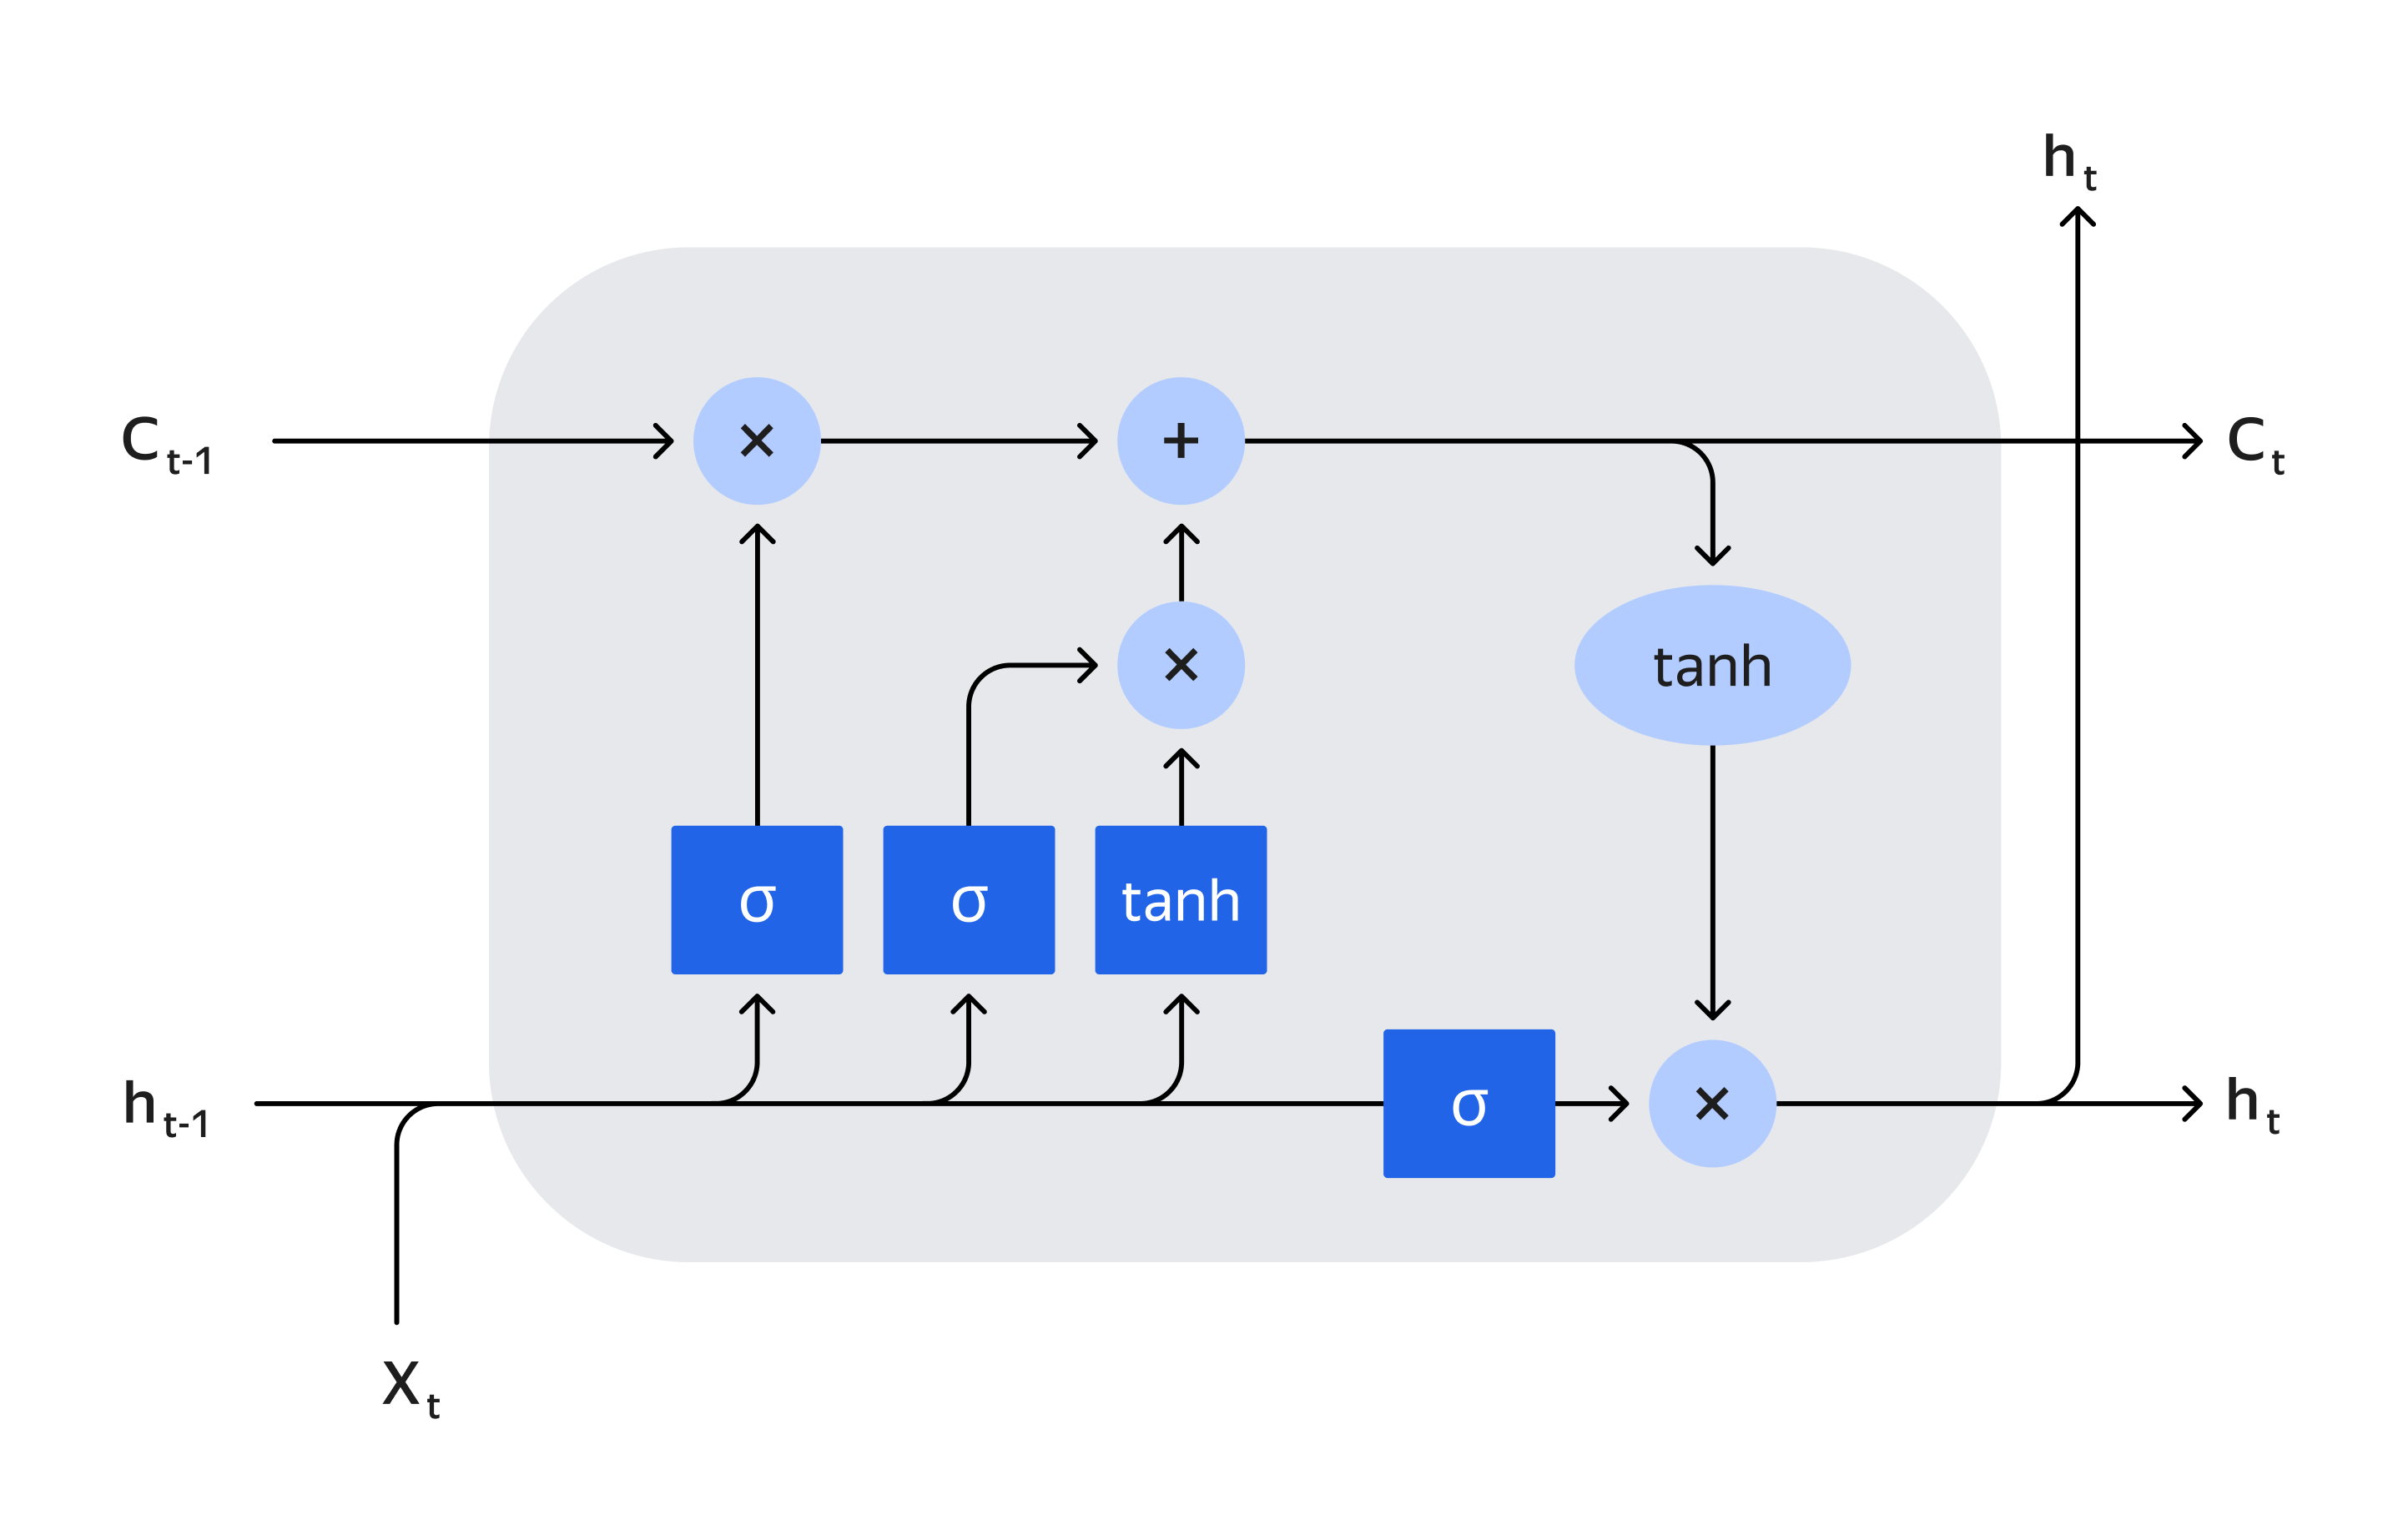

In [1]:
from IPython.display import Image
from ml_dl_experiments import settings

Image(settings.SOURCE_PATH+"ml_dl/RNN/LSTM.png", width=600, height=1000)

- Прошлое состояние $C_{t−1}$​ умножается на выход первого σ-блока (forget gate). 

- Параллельно входные данные $x_t$​ и предыдущее скрытое состояние $h_{t−1}$​ через tanh преобразуют входные значения, и

- затем второй σ-блок (input gate) выбирает, какую часть этих значений запомнить.

- Сложение двух результатов даёт текущее состояние $C_t$​. 

- Наконец, $C_t$​ через tanh и третий σ-блок (output gate) даёт выход $h_t$​.

# GRU

GRU (Gated Recurrent Unit) — более простая альтернатива LSTM. Она объединяет forget- и input-гейты в один update gate и вместо cell state использует только hidden state, при этом расчёты чуть сложнее, чем в классической RNN. Архитектура GRU проще LSTM, поэтому сети легче и быстрее обучаются, при этом сохраняют способность моделировать долгосрочные зависимости.

Рассмотрим, какие формулы скрываются «под капотом» GRU:

- Update gate
$$
z_t​=σ(W_z​[h_{t−1}​,x_t​]+b_z​)
$$
- Reset gate
$$
r_t​=σ(W_r​[h_{t−1}​,x_t​]+b_r​)
$$    
   
- Обновление состояния
$$
\tilde{h}_t​=tanh(W_h​[r_t​⋅h_{t−1}​,x_t​]+b_h​)
$$    
$$
h_t​=(1−z_t​)⋅h_{t−1}​+z_t​⋅\tilde{h}_t​
$$
Схема шага работы ячейки в архитектуре GRU:

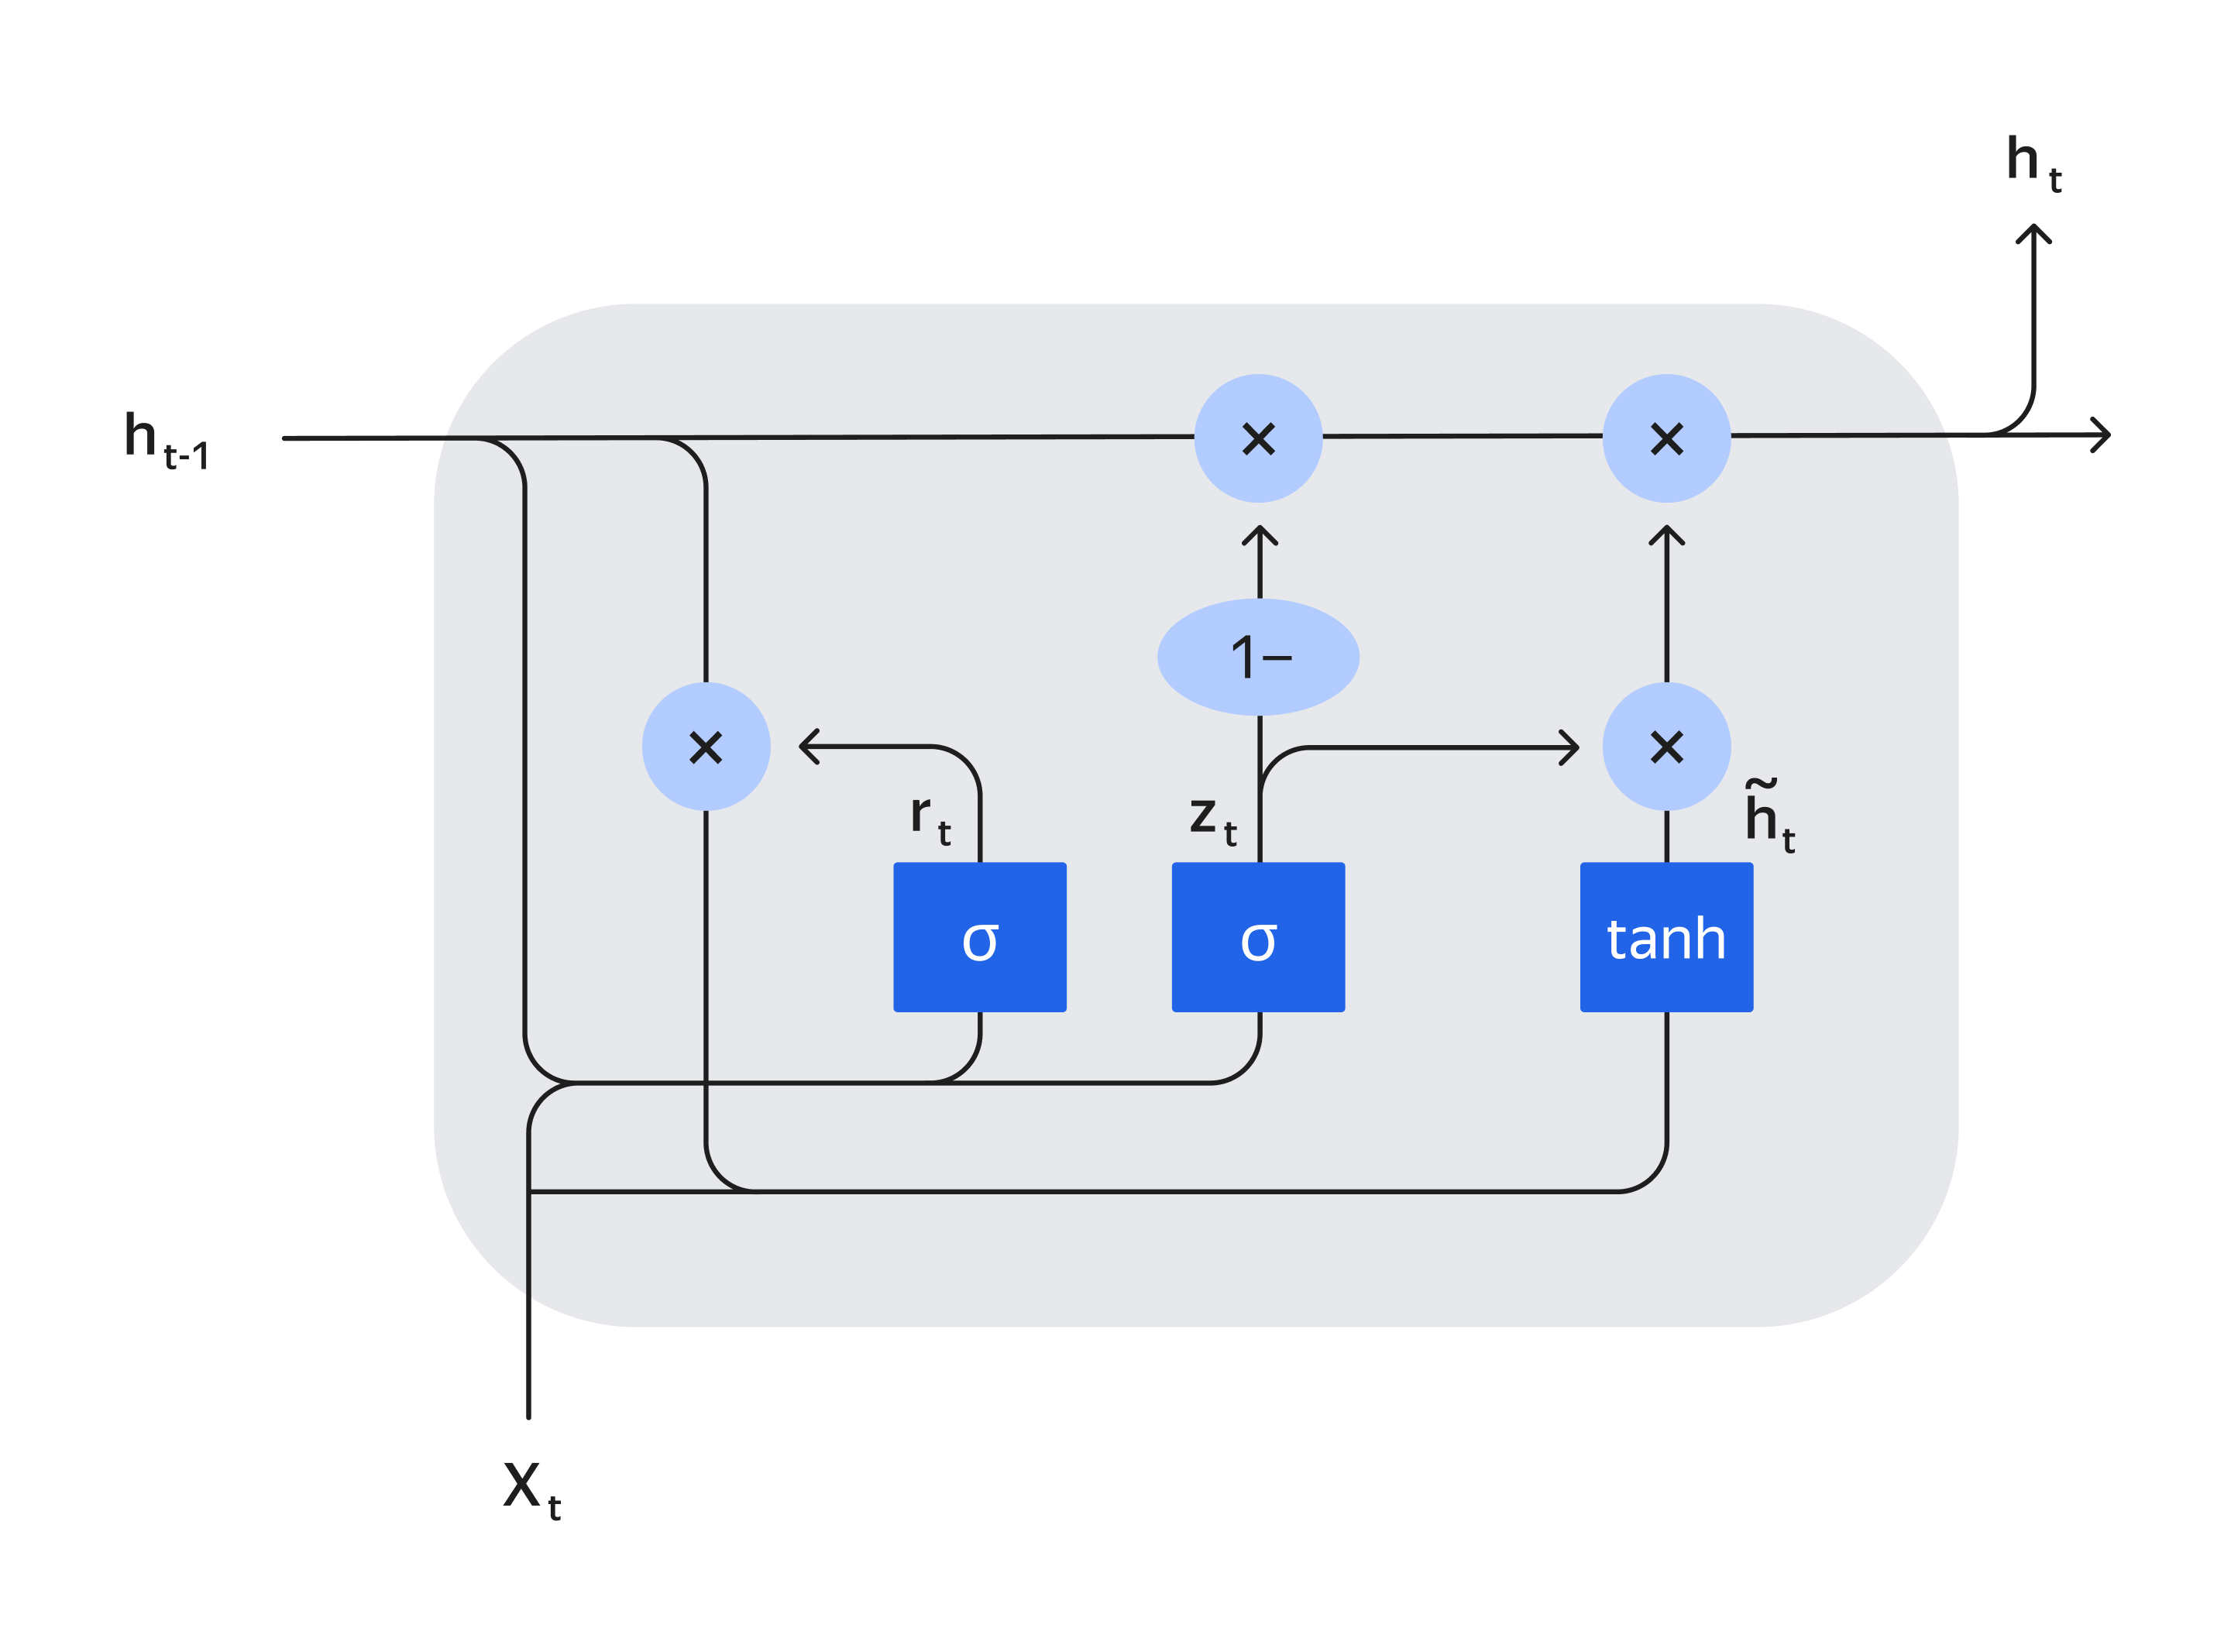

In [2]:
Image(settings.SOURCE_PATH+"ml_dl/RNN/GRU.png", width=600, height=1000)

На вход поступают текущий вектор xt​ и предыдущее скрытое состояние ht−1​.
Два гейта c сигмоидой работают так: 

- reset-гейт $r_t$​ решает, какую часть $h_{t−1}$​ «обнулить»,

- update-гейт $z_t$​ определяет, какую долю старого состояния сохранить.

- Поэлементное произведение $r_t$​ и $h_{t−1}$​, а также вход $x_t$​ подаются через $tanh$, чтобы получить вектор $\tilde{h}_t​.

- Итоговое скрытое состояние ht​ сочетает старое состояние и новую полезную информацию, которую сеть запомнила.

Таким образом, GRU без отдельного cell state умеет избирательно сохранять и обновлять информацию.

## Как выбрать подходящую архитектуру

Выбор конкретной архитектуры зависит от конкретной задачи, длины входных последовательностей, требований к скорости и объёму вычислений. Вот основные моменты, на которые надо обращать внимание при выборе.

- **Посмотрите на длину последовательностей**

Для коротких последовательностей (до 50 токенов) можно использовать RNN, особенно если задача простая. 
Для средних последовательностей (50–200 токенов) GRU даст лучшее соотношение качества и скорости. 
Если последовательности длинные (более 200 токенов) и важно сохранить дальние зависимости, используйте LSTM.

- **Оцените характер зависимости в данных**

Если контекст влияет в пределах пары предложений, достаточно GRU. 
Если важно учитывать события, произошедшие давно (например, в начале текста), выбирайте LSTM. 
Если зависимостей почти нет, например, текст — список покупок, где важны только слова, но не порядок, может подойти простой вариант — RNN или классические методы.

- **Учтите требования к скорости и ресурсам**

GRU и RNN быстрее обучаются и работают на инференсе, подходят для ограниченных устройств — например, для смартфонов и встроенных систем. 

LSTM работает медленнее, но если вычислительных ресурсов достаточно, то эта архитектура мощнее.

| Задача                                 | Предпочтительная архитектура | Почему                                      |
|----------------------------------------|-----------------------------|---------------------------------------------|
| Предсказание слова в короткой фразе    | RNN                         | Быстро, эффективно, без избыточности        |
| Классификация отзывов (до 150 слов)    | GRU                         | Учитывает контекст, быстро обучается        |
| Перевод длинных предложений            | LSTM                        | Сохраняет дальние зависимости              |
| Генерация поэмы или истории            | LSTM                        | Требуется долгосрочная память              |
| Анализ юридических или медицинских текстов | LSTM                     | Сложные, длинные, много смысла             |

## Реализация в PyTorch

В PyTorch блоки GRU и LSTM работают по такому же принципу, как и рекуррентный блок nn.RNN из предыдущих уроков. Разница — в используемом классе: nn.GRU, nn.LSTM или nn.RNN. Входные параметры и выходные значения имеют одинаковый смысл и формат для всех трёх реализаций.

```py

import torch

import torch.nn as nn


# Параметры «игрушечного» примера
batch_size  = 4    # сколько последовательностей в батче
seq_len     = 10   # длина каждой последовательности
input_dim   = 16   # размер эмбеддинга / признаков на шаге
hidden_dim  = 32   # размер скрытого состояния LSTM


x = torch.randn(batch_size, seq_len, input_dim)   # (B, T, D)


# ==== LSTM ====
lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=False)
lstm_out, _ = lstm(x)


print("Lstm output :", lstm_out.shape)  # (4, 10, 32)
```

Здесь для размера скрытого состояния hidden_dim=32 LSTM возвращает тензор lstm_uni размера (4, 10, 32), где 4 — размер батча, 10 — длина последовательностей, 32 — размер скрытого состояния.

# Двунаправленные RNN и их применение

Мы познакомились с классической архитектурой RNN и её улучшениями — LSTM и GRU. Все эти модели по умолчанию «читали» входные последовательности слева направо, постепенно запоминая контекст.

В этом уроке вы познакомитесь с двунаправленными RNN — они «читают» текст не только слева направо (от первого слова к последнему), но и справа налево (от последнего к первому). Таким образом, для подсчёта выхода для каждого токена используется и контекст, накопленный по «прошлому», и контекст из «будущего». Такой подход заметно улучшает качество предсказаний при обработке последовательностей. 

## Идея и преимущества двунаправленных RNN

Однонаправленная RNN (обычно «слева → направо») воспринимает последовательность только в том порядке, в котором её получают на входе. Каждое скрытое состояние $h_t​=RNN(x_t​,h_{t−1}​)$ зависит от текущего токена $x_t$​ и предыдущего контекста $h_{t−1}$​.

Это накладывает несколько ограничений:

- Модель не учитывает будущий контекст. Например, анализируя слева направо фразу «важный ключ к решению задачи...», в момент обработки слова «ключ» модель ещё не знает, о каком ключе идёт речь: это ключ от двери, ключ как родник или ключ к задаче.
  
- Длинный зависимый контекст затухает. Даже с LSTM и GRU информация о далёких позициях теряется быстрее, если она конкурирует с новым входом той же направленности.
   
- Однонаправленные модели трудно регуляризовать. При применении dropout может «обнулиться» пара токенов, из-за чего весь накапливаемый контекст в модели может тоже обнулиться. Наличие контекста, посчитанного по токенам «из будущего», решает эту проблему и делает обучение более стабильным.

Из желания обойти эти ограничения и возникла идея двунаправленности. 

>Двунаправленная (bidirectional) рекуррентная нейронная сеть, обрабатывая каждый токен, считает два скрытых состояния: одно считается при последовательной обработке токенов слева направо, второе — справа налево.

Объединяя эти скрытые состояния, модель может использовать контекст как из прошлого, так и из будущего.

## Архитектура двунаправленной RNN

После добавления второго потока, читающего последовательность справа налево, появляется и второе скрытое состояние. Таким образом, для каждого временного шага t получаем два скрытых состояния:

$$
\overrightarrow{h}_t​=\overrightarrow{RNN}(x_t​,h_{t−1}​)
$$
$$
\overleftarrow{h}_t​​=\overleftarrow{RNN}(x_t​,h_{t−1}​)
$$
Эти скрытые состояния считаются независимыми друг от друга RNN-блоками. 

После того как два состояния посчитаны, нужно объединить их. Есть разные методы объединения скрытых состояний. Наиболее часто используются такие:

- Конкатенация, или «склеивание» двух векторов: $h_t​=concat(\overrightarrow{h}_t​​;\overleftarrow{h}_t)​$​. Когда мы «склеиваем» два вектора размера hidden_size, получается вектор vht​ размера 2⋅hidden_size.

- Поэлементная сумма:$ h_t​=\overrightarrow{h}_t + \overleftarrow{h}_t $​. Размер итогового вектора $h_t$​ равен hidden_size — такой же, как и у исходных векторов.

- Взвешенная сумма: $h_t​=α\overrightarrow{h}_t​​+β\overleftarrow{h}_t​$​. Здесь α и β — обучаемые параметры.

Между этими методами нет больших различий, все они справляются с задачей — сохраняют информацию обоих исходных векторов. По умолчанию можно использовать конкатенацию. 

Полученное скрытое состояние $h_t​$ можно использовать для решения множества задач, как и в классических RNN.

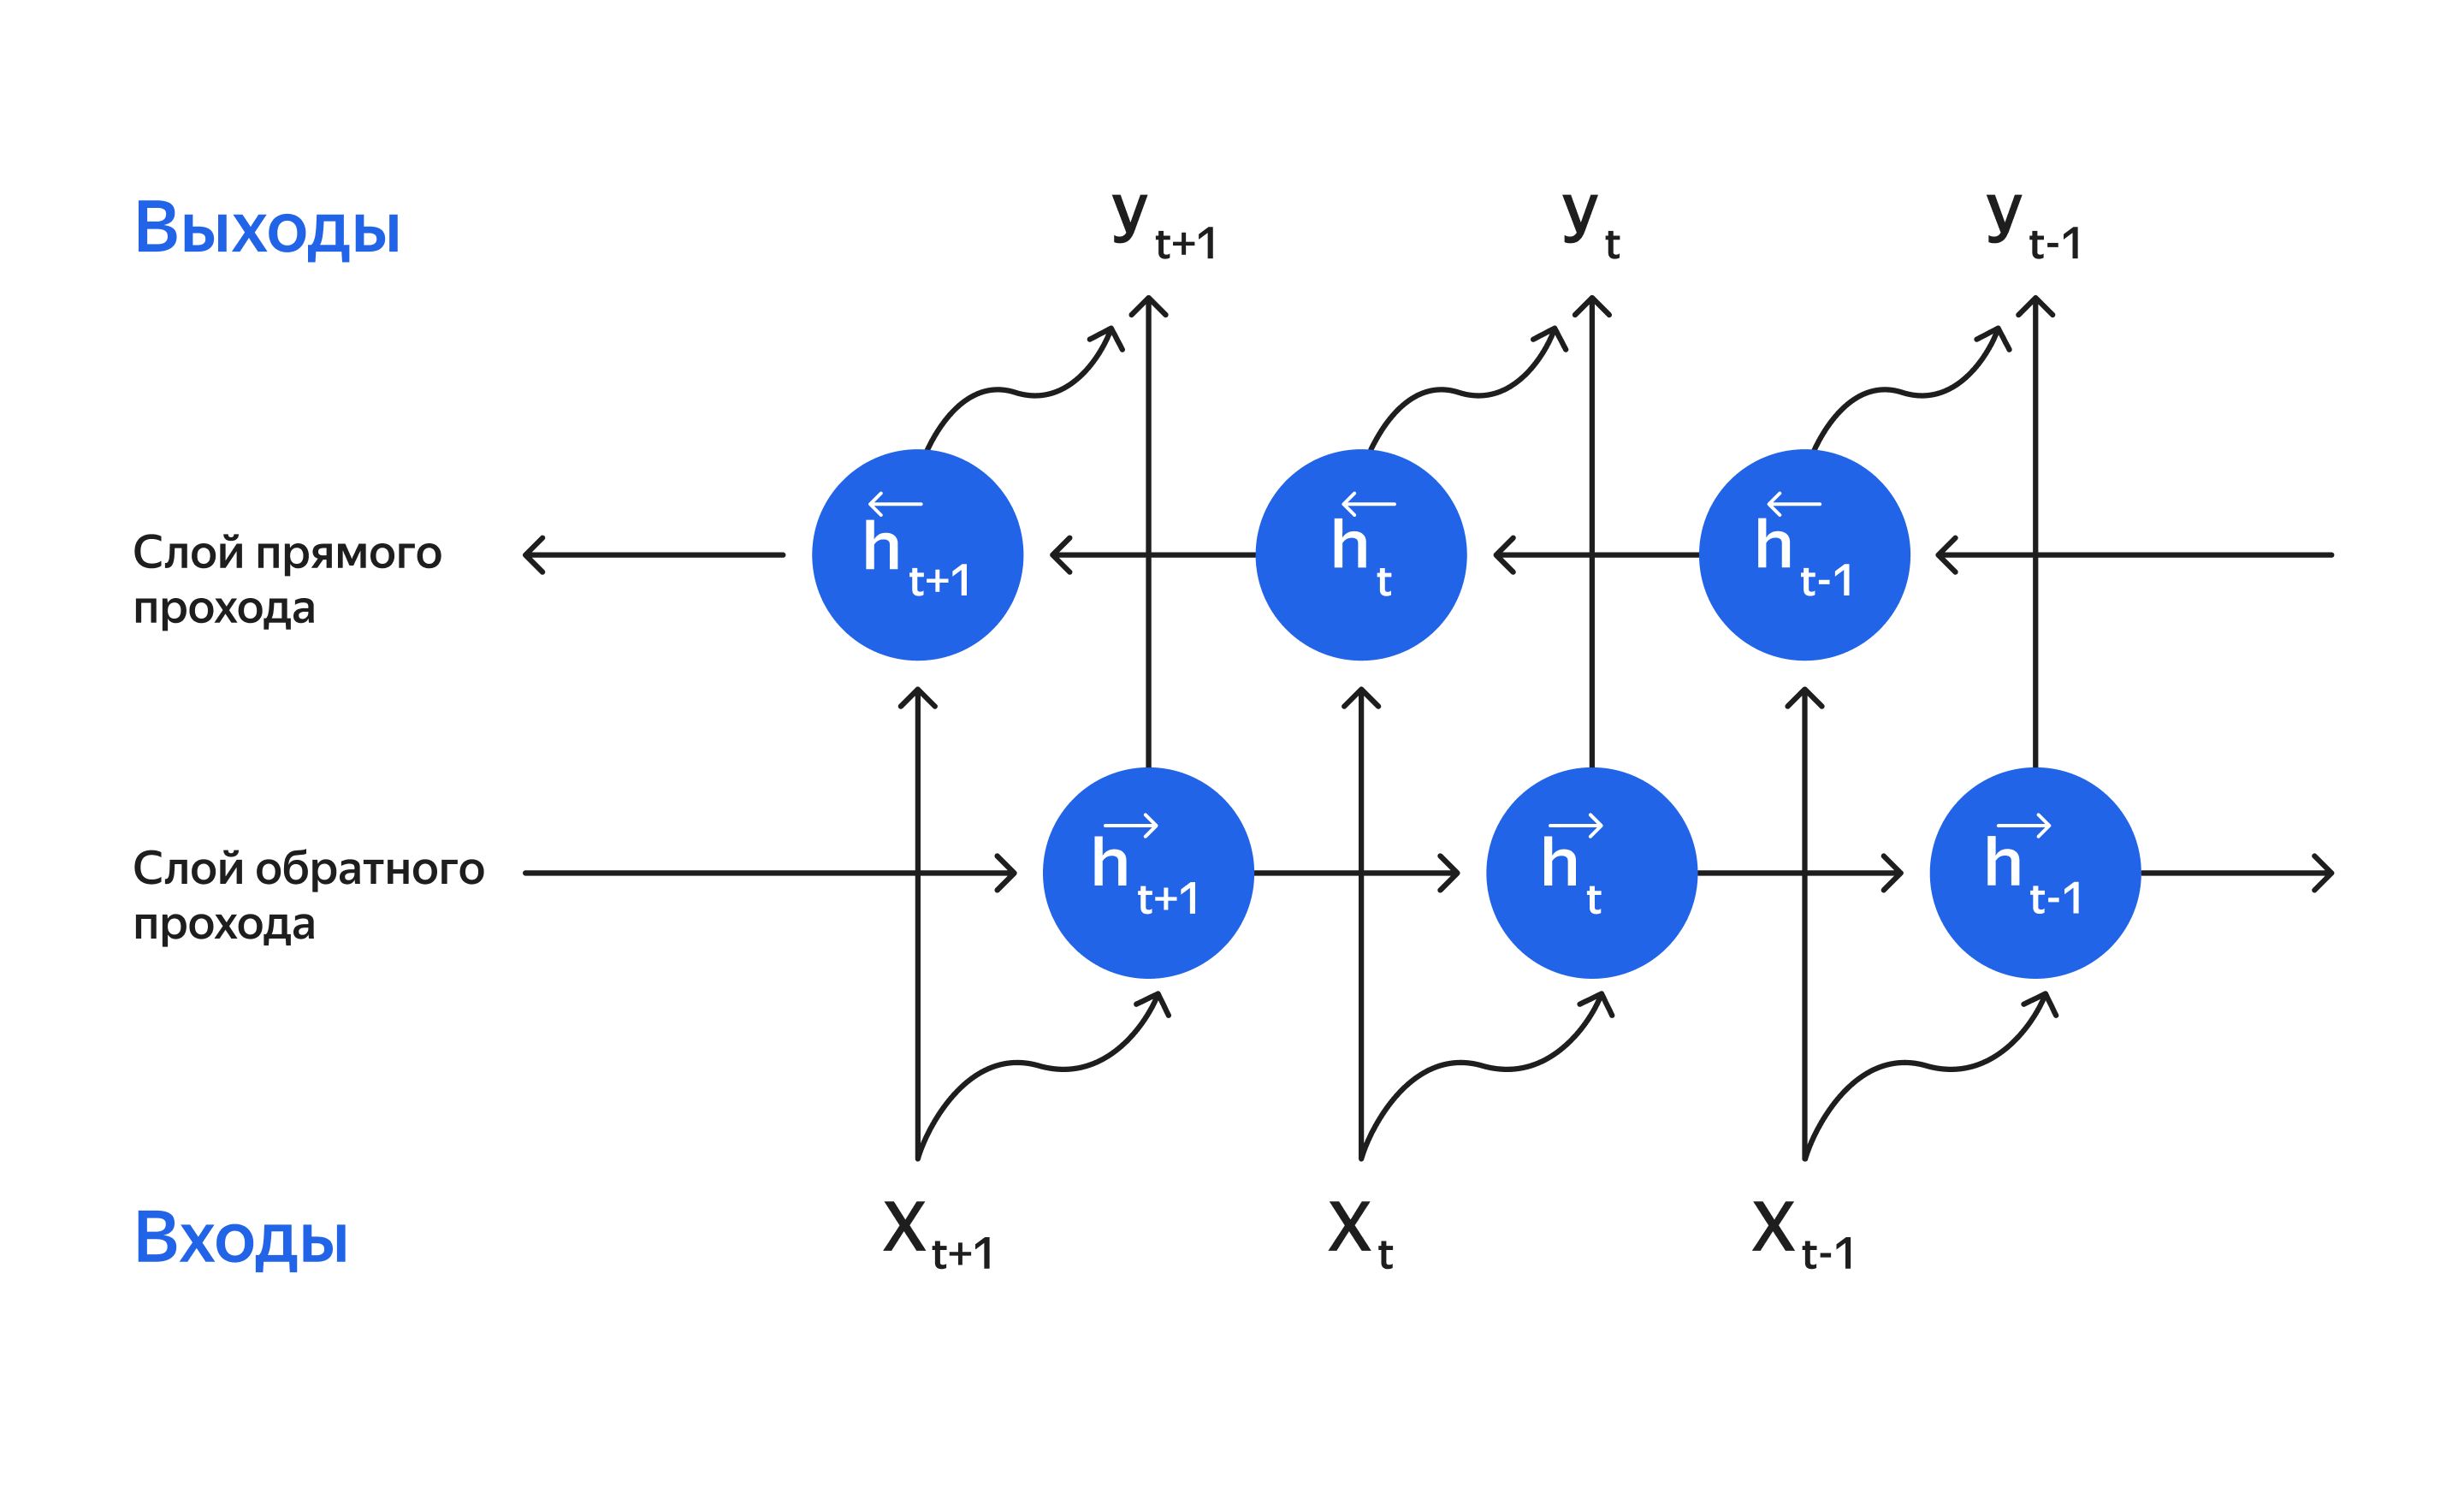

In [1]:
from IPython.display import Image
from ml_dl_experiments.settings import settings

Image(settings.SOURCE_PATH + "/ml_dl/RNN/bidirRNN.png", width=1000, height=1000)

На схеме показано, что для каждого входного $x_t$​ токена считается два скрытых состояния. При этом выходы $y_t$​ считаются по обоим скрытым состояниям.

## Реализация в PyTorch

Двунаправленность реализуется просто: в конструктор рекуррентного блока нужно передать параметр `bidirectional=True`. Это работает и для классического RNN блока, и для GRU, и для LSTM.

При выставленном параметре `bidirectional=True` рекуррентный блок, применённый к батчу последовательностей, будет возвращать тензор размера не `(batch_size, seq_len, hidden_size)`, как мы привыкли, а `(batch_size, seq_len, hidden_size * 2)`. То есть скрытые состояния с двух проходов конкатенируются друг с другом и получается скрытое состояние вдвое большего размера.

```py
import torch

import torch.nn as nn


# Параметры «игрушечного» примера
batch_size  = 4    # сколько последовательностей в батче
seq_len     = 10   # длина каждой последовательности
input_dim   = 16   # размер эмбеддинга / признаков на шаге
hidden_dim  = 32   # размер скрытого состояния LSTM


x = torch.randn(batch_size, seq_len, input_dim)   # (B, T, D)


# ==== 1. Обычная (однонаправленная) LSTM ====
lstm_uni = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=False)
out_uni, _ = lstm_uni(x)


print("Unidirectional output :", out_uni.shape)  # (4, 10, 32)


# ==== 2. Двунаправленная LSTM (bidirectional=True) ====
lstm_bi = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
out_bi, _ = lstm_bi(x)


print("Bidirectional output :", out_bi.shape)   # (4, 10, 64)  -> 32 * 2
```

В примере выше для размера скрытого состояния hidden_dim=32:

 - Однонаправленная LSTM возвращает тензор lstm_uni размера (4, 10, 32), где 4 — размер батча, 10 — длина последовательностей, 32 — размер скрытого состояния.

- Двунаправленная LSTM возвращает тензор lstm_bi размера (4, 10, 64), то есть скрытые состояния сконкатенировались.

## Практическое применение двунаправленных RNN

Когда двунаправленные архитектуры полезны, а когда — неприменимы?

### **Когда двунаправленные RNN эффективны**

Рекомендации просты. Использовать двунаправленную RNN имеет смысл, если:

- в токенах из «будущего» может храниться полезная для решения задачи информация

- и по условию задачи на момент обработки токена $x_t$​ для модели доступны токены $x_{t+1}​,x_{t+2}​,...$

Например, двунаправленные рекуррентные нейросети особенно полезны в таких задачах:

- Распознавание именованных сущностей (Named Entity Recognition, NER). Когда сеть находит и классифицирует «имена»: организации, людей, локации, важно знать весь контекст, в том числе — что следует за распознаваемым словом. Например, в предложении «”Орёл” выиграл матч со счётом 3:1» слово «Орёл» можно интерпретировать правильно только в контексте всей фразы.

- Разметка частей речи (Part-of-Speech Tagging). Правильный выбор части речи зависит от контекста с обеих сторон. Слово «мой» может быть местоимением или глаголом, и это становится понятно, если знать слова перед ним и после него.

- Анализ настроения текста (Sentiment Analysis). Часто эмоциональная окраска предложения зависит от противопоставлений или уточнений в конце. Например, «Я думал, фильм будет захватывающим, но он оказался скучным» — правильное понимание слова «захватывающим» требует знания всего контекста.

- Текстовая классификация (Text Classification) — когда нужно принимать решение по всей последовательности, двунаправленная модель помогает учитывать контекст с обеих сторон уже при построении внутренних представлений на каждом шаге.

### **Где двунаправленные RNN не применяются или вредны**

Есть сценарии, в которых использование двунаправленных RNN неуместно или невозможно:

- Онлайн-прогнозирование. Модель должна делать выводы в реальном времени по мере поступления данных, и у неё нет доступа к будущему. Двунаправленная сеть не сможет работать в таких условиях, так как она требует полный вход целиком.

- Генерация текста. Здесь модель предсказывает следующее слово на основе предыдущих. Использовать будущий контекст — значит «заглянуть в ответ», что нарушает условие задачи.

- Обработка сложных и долгих последовательностей в условиях ограниченных ресурсов. Двунаправленные модели обычно тяжелее и требуют в два раза больше вычислений и памяти, что может быть критично при работе на мобильных устройствах или при длинных текстах.

Таким образом, важно хорошо понимать условия задачи и имеющиеся ограничения, чтобы принять грамотное решение об использовании двунаправленной RNN.

# Выжимка статьи "Understanding LSTM Networks"

## Основная проблема RNN

**Проблема долгосрочных зависимостей**: Обычные рекуррентные нейронные сети не могут запоминать информацию на длинных расстояниях в последовательностях.

*Пример*: 
- **Короткая зависимость**: "the clouds are in the **sky**" - легко предсказать
- **Длинная зависимость**: "I grew up in France... I speak fluent **French**" - требует запоминания контекста

## Что такое LSTM?

**Long Short Term Memory** - специальный тип RNN, созданный для решения проблемы долгосрочных зависимостей.

**Ключевая идея**: клеточное состояние (cell state) - "конвейерная лента", проходящая через всю цепь.

## Механизм работы LSTM

### 1. Forget Gate (Вентиль забывания)
Решает, какую информацию выбросить из клеточного состояния:

$$f_t = \sigma (W_f \cdot [h_{t-1}, x_t] + b_f)$$

### 2. Input Gate (Вентиль входа)
Решает, какую новую информацию сохранить:

$$i_t = \sigma (W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

### 3. Обновление состояния

$$C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$$

### 4. Output Gate (Вентиль выхода)
Решает, какую информацию вывести:

$$o_t = \sigma (W_o [h_{t-1}, x_t] + b_o)$$
$$h_t = o_t * \tanh (C_t)$$

## Варианты LSTM

### Peephole Connections
Вентили смотрят на клеточное состояние:

$$f_t = \sigma (W_f [C_{t-1}, h_{t-1}, x_t] + b_f)$$

### GRU (Gated Recurrent Unit)
Упрощенная версия:

$$z_t = \sigma (W_z \cdot [h_{t-1}, x_t])$$
$$r_t = \sigma (W_r \cdot [h_{t-1}, x_t])$$
$$\tilde{h}_t = \tanh (W \cdot [r_t * h_{t-1}, x_t])$$
$$h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t$$

## Ключевые выводы

1. **LSTM решает проблему долгосрочных зависимостей**, которая не под силу обычным RNN
2. **Клеточное состояние** - главное отличие, позволяющее сохранять информацию надолго
3. **Три вентиля** обеспечивают точный контроль над информационным потоком
4. **LSTM достигли выдающихся результатов** в задачах обработки последовательностей
5. **Дальнейшее развитие** - механизмы внимания (attention) и другие усовершенствования

*"LSTM специально созданы для запоминания информации на долгие периоды - это их поведение по умолчанию, а не то, чему они с трудом обучаются."*

# Практика.

# Реализация двунаправленных LSTM

## Архитектурные улучшения RNN

В предыдущих уроках вы познакомились с архитектурными улучшениями классической RNN:

- **GRU и LSTM** — модели, лучше работающие с памятью и выдающие более высокое качество
- **Двунаправленный подход** — помогает учитывать контекст с обеих сторон, что даёт модели возможность работать лучше на определённом классе задач

В этом уроке вам предстоит совместить два этих подхода, реализовать и обучить **Bidirectional LSTM** для задачи предсказания пропущенного слова в тексте. Внутри модели нужно будет настроить возможность выбора:

- Рекуррентного блока
- Метода работы со скрытыми состояниями с двух разных направлений двунаправленной сети


## Описание задачи

В этом уроке вам предстоит решить задачу **masked word prediction** — предсказания слова, скрытого в предложении.

### Формулировка задачи

Представим предложение: *"The stock market crashed yesterday."* Выберем одно слово (например, "crashed"), заменим его на `<MASK>` и подадим на вход модели такую последовательность:

```
"The stock market <MASK> yesterday."
```

**Задача модели** — на основе этой последовательности угадать, какое слово было замаскировано. Это типичная **многоклассовая классификация**, где каждый класс — слово из словаря.

### Обоснование выбора модели

Чтобы угадать слово в середине, модель должна видеть **весь контекст**. Например, есть предложение:

```
"The quick brown <MASK> jumps over the lazy dog"
```

Чтобы предсказать слово "fox", нужно и то, что до него, и то, что после.

**Поэтому для решения такой задачи подойдёт двунаправленная сеть.**

### Как формируется датасет

Для каждого предложения мы:

1. **Выбираем слово-таргет** из предложения
2. **Вокруг этого слова строим окно контекста** — например, по 3 слова до и после
3. **Заменяем целевое слово на `<MASK>`** и сохраняем список слов с заменённым словом как входной вектор **X**
4. **Слово, которое было замаскировано**, становится таргетом **y**
5. **Повторяем пункты 1–4** для всех слов в предложении, вокруг которых можно построить окно контекста. Если предложение слишком короткое — оно пропускается

**Пример:**

| Оригинал | Вход (X) | Таргет (y) |
|----------|----------|------------|
| language models are cool | language `<MASK>` are cool | models |
| deep learning is amazing | deep `<MASK>` is amazing | learning |

## Что делает модель

1. **Embedding-слой** преобразует входные индексы слов в векторы признаков (обычно 64–256 размерности)

2. **Двунаправленная RNN, GRU или LSTM** обрабатывает последовательность и слева направо, и справа налево

3. **Скрытые состояния** на позиции `<MASK>` из обоих направлений объединяются — складываются (`sum`) или конкатенируются (`concat`)

4. Далее всё идёт как в обычной задаче классификации: полученное представление подаётся в **Linear-слой**, который выдаёт вектор длины `vocab_size`. Этот вектор интерпретируется как вероятности по словарю и выбирается наиболее вероятное слово

## Лосс-функция

Мы решаем задачу **многоклассовой классификации**. На выходе у нас вектор значений для каждого токена словаря, который хочется преобразовать в распределение вероятностей. Поэтому мы используем **`CrossEntropyLoss` из PyTorch**.

Кросс-энтропийная функция потерь в PyTorch автоматически применяет `LogSoftmax`, то есть:

- Преобразует значения после линейного слоя в распределения вероятностей
- Считает их логарифмы
- Сравнивает с истинным индексом слова (y)

## Какую задачу будем решать в уроке

При токенизации слово может разбиться на несколько токенов, так что для предсказания пропущенного слова иногда надо заменять не один токен на `<MASK>`, а все токены, соответствующие этому слову. 

Для этого нужно дополнительно реализовать пре- и постпроцессинг данных, что может отвлечь от основной идеи. 

In [ ]:
# импортируем библиотеки, которые пригодятся для задачи
import torch

import torch.nn as nn

import re

import random

from datasets import load_dataset

from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset

from transformers import BertTokenizerFast

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from ml_dl_experiments.settings import settings


random.seed(42)
torch.manual_seed(42)


# функция для "чистки" текстов
def clean_string(text):
    # приведение к нижнему регистру
    text = text.lower()
    # удаление всего, кроме латинских букв, цифр и пробелов
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # удаление дублирующихся пробелов, удаление пробелов по краям
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# загружаем датасет WikiText-2

dataset = load_dataset(path=settings.SOURCE_PATH+"datasets/wikitext", "wikitext-2-raw-v1", split="train")


# длины последовательностей в датасете
# seq_len = 7 => 3 токена до <MASK> + токен <MASK> + 3 токена после
seq_len = 7


# удаляем слишком короткие тексты
texts = [line for line in dataset["text"] if len(line.split()) >= seq_len]


# "чистим" тексты
cleaned_texts = list(map(clean_string, texts))


# для упрощения используем только max_texts_count текстов
max_texts_count = 7000


# разбиение на тренировочную и валидационную выборки
val_size = 0.05

train_texts, val_texts = train_test_split(cleaned_texts[:max_texts_count], test_size=val_size, random_state=42)
print(f"Train texts: {len(train_texts)}, Val texts: {len(val_texts)}")


# класс датасета
class MaskedBertDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_len=7):
        # self.samples - список пар (x, y)
        # x - токенизированный текст с пропущенным токеном
        # y - пропущенный токен
        self.samples = []


        for line in texts:
            token_ids = tokenizer.encode(line, return_tensors='pt')


            # если строка слишком короткая, то пропускаем её
            if len(token_ids) < seq_len:
                continue


            # проходимся по всем токенам в последовательности
            for i in range(1, len(token_ids) - 1):
                '''
                context - список из seq_len // 2 токенов до i-го токена, токена tokenizer.mask_token_id, и seq_len // 2 токенов после i-го токена
                '''
                context = token_ids[max(0, i - seq_len//2): i] + [tokenizer.mask_token_id] + token_ids[i+1: i+1+seq_len//2]


                # если контекст слишком короткий, то пропускаем его
                if len(context) < seq_len:
                    continue


                target = token_ids[i]


                self.samples.append((context, target))
           
    def __len__(self):
        return len(self.samples)


    def __getitem__(self, idx):
        x, y = self.samples[idx][0], self.samples[idx][1]
        return torch.tensor(x), torch.tensor(y)


# загружаем токенизатор
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")


# тренировочный и валидационный датасеты
train_dataset = MaskedBertDataset(train_texts, tokenizer, seq_len=seq_len)
val_dataset = MaskedBertDataset(val_texts, tokenizer, seq_len=seq_len)


# даталоадеры
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

KeyboardInterrupt: 